## Exploratory Data Analysis/Time Series Adjustment

This notebook covers some of the preliminary EDA that I conducted. The second part of this notebook is my process for creating a representation of a game as the set of the 3 previous games' box stats. 

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('clean_nba_betting_dataframe_full.csv', parse_dates=['date_2'])

In [3]:
df.head()

,date_2,gid,team_slug_1,fg_1,fga_1,fg%_1,3p_1,3pa_1,3p%_1,ft_1,...,stl_2,blk_2,tov_2,pf_2,pts_2,home_2,betting_line_2,off_rating_1,off_rating_2,over_under
0,2013-10-30,201310300DAL,ATL,37,76,0.487,8,24,0.333,27,...,7,2,20,22,118,1,-6.0,108.28,117.23,195.5
1,2013-10-30,201310300DAL,DAL,44,77,0.571,11,24,0.458,19,...,16,5,17,20,109,0,6.0,117.23,108.28,195.5
2,2013-11-01,201311010ATL,ATL,36,77,0.468,10,23,0.435,20,...,5,6,12,25,95,0,3.5,108.92,101.45,195.0
3,2013-11-01,201311010ATL,TOR,40,88,0.455,7,23,0.304,8,...,7,3,13,12,102,1,-3.5,101.45,108.92,195.0
4,2013-11-03,201311030LAL,ATL,40,90,0.444,9,22,0.409,14,...,5,7,13,24,105,1,-1.0,99.62,101.55,206.5


#### Imputing total score for a game

In [4]:
df['game_total_score'] = df['pts_1'] + df['pts_2']

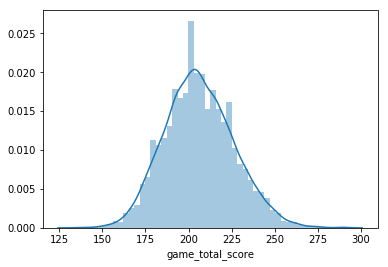

In [5]:
sns.distplot(df.game_total_score)

Text(0.5,0,'Total Points')

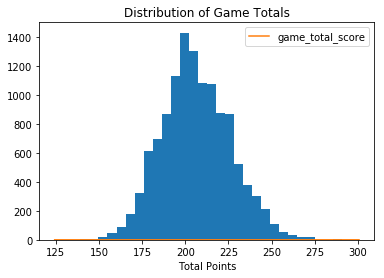

In [6]:
plt.hist(df.game_total_score, bins=30)
sns.kdeplot(df.game_total_score)
plt.title("Distribution of Game Totals")
plt.xlabel("Total Points")

In [7]:
df.columns

Index(['date_2', 'gid', 'team_slug_1', 'fg_1', 'fga_1', 'fg%_1', '3p_1',
       '3pa_1', '3p%_1', 'ft_1', 'fta_1', 'ft%_1', 'orb_1', 'drb_1', 'trb_1',
       'ast_1', 'stl_1', 'blk_1', 'tov_1', 'pf_1', 'pts_1', 'home_1',
       'betting_line_1', 'team_slug_2', 'fg_2', 'fga_2', 'fg%_2', '3p_2',
       '3pa_2', '3p%_2', 'ft_2', 'fta_2', 'ft%_2', 'orb_2', 'drb_2', 'trb_2',
       'ast_2', 'stl_2', 'blk_2', 'tov_2', 'pf_2', 'pts_2', 'home_2',
       'betting_line_2', 'off_rating_1', 'off_rating_2', 'over_under',
       'game_total_score'],
      dtype='object')

In [8]:
offensive_stats = df[['off_rating_1', 'off_rating_2', 'over_under',
       'game_total_score']]

In [9]:
offensive_stats.corr()

,off_rating_1,off_rating_2,over_under,game_total_score
off_rating_1,1.000000,0.185108,0.175838,0.603108
off_rating_2,0.185108,1.000000,0.175838,0.603108
over_under,0.175838,0.175838,1.000000,0.492304
game_total_score,0.603108,0.603108,0.492304,1.000000


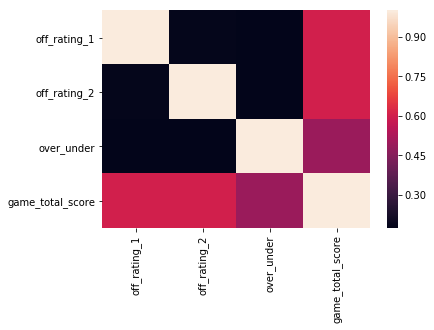

In [10]:
sns.heatmap(offensive_stats.corr())

### Functions to return merged dataframe w/ 3 prior games for all teams

In [11]:
team_handles_dict = {'Toronto Raptors': 'TOR',
                     'Boston Celtics': 'BOS',
                     'Philadelphia 76ers': 'PHI',
                     'Cleveland Cavaliers': 'CLE',
                     'Indiana Pacers': 'IND',
                     'Miami Heat': 'MIA',
                     'Milwaukee Bucks': 'MIL',
                     'Washington Wizards': 'WAS',
                     'Detroit Pistons': 'DET',
                     'Charlotte Hornets': 'CHO',
                     'Charlotte Bobcats': 'CHA',
                     'New York Knicks': 'NYK',
                     'Brooklyn Nets': 'BRK',
                     'Chicago Bulls': 'CHI',
                     'Orlando Magic': 'ORL',
                     'Atlanta Hawks': 'ATL',
                     'Houston Rockets': 'HOU',
                     'Golden State Warriors': 'GSW',
                     'Portland Trail Blazers': 'POR',
                     'Oklahoma City Thunder': 'OKC',
                     'Utah Jazz': 'UTA',
                     'New Orleans Pelicans': 'NOP',
                     'San Antonio Spurs': 'SAS',
                     'Minnesota Timberwolves': 'MIN',
                     'Denver Nuggets': 'DEN',
                     'L.A. Clippers': 'LAC',
                     'L.A. Lakers': 'LAL',
                     'Sacramento Kings': 'SAC',
                     'Dallas Mavericks': 'DAL',
                     'Memphis Grizzlies': 'MEM',
                     'Phoenix Suns': 'PHO'}

#### team_df_create: 
- Takes in a dataframe and a team slug and returns a dataframe with just the team's games, from the team's perspective

In [12]:
def team_df_create(data, team):
    teams_games = []
    for i, row in enumerate(data['team_slug_1']):
        if row == team:
            teams_games.append(data.loc[i])
    return pd.DataFrame(teams_games, columns=df.columns, index=range(len(teams_games)))

#### get_3_back: 
- Takes in a dataframe containing one team's games, a list of columns to duplicate, and a list of dates when the games occurred, and returns a dataframe with each game represented as the box score stats for the previous 3 games.

In [13]:
def get_3_back(df_team, cols_to_double, date_list):
    game_3_back = pd.DataFrame(df_team[:-3][['gid'] + cols_to_double].values, index=date_list[3:], 
                          columns=['gid'] + [x+'_3' for x in cols_to_double])

    game_2_back = pd.DataFrame(df_team[:-2][['gid'] + cols_to_double].values, index=date_list[2:], 
                          columns=['gid'] + [x+'_2' for x in cols_to_double])

    game_1_back = pd.DataFrame(df_team[:-1][['gid'] + cols_to_double].values, index=date_list[1:], 
                          columns=['gid'] + [x+'_1' for x in cols_to_double])
    
    merged_games_df = game_1_back.join(game_2_back, lsuffix = '_1', rsuffix= '_2')
    merged_games_df = merged_games_df.join(game_3_back, rsuffix='_3')
    
    
    return merged_games_df

#### replace_season_openers: 
- This function takes in a dataframe with NBA games, and looks for the first game in every season. It then adds these games, plus the second and third games, to a list of games to drop from each season.

I felt it necessary to remove the first three games from every season, because these games do not have a full set of historical games yet to base predictions off of. Although I could have imputed information from the previous season to try and make estimates for these features, I felt that because of the shift in team performance from season to season, that method would be an naccurate way to make predictions on the early games of a season

In [14]:
def replace_season_openers(df):
    
    new_season_games = []

    for i, x in enumerate(df.index[1:-1]):
        if (df.index[i] - df.index[i-1]).days > 30:
            new_season_games.extend([df.index[i], df.index[i+1], df.index[i+2]])
    
    df.drop([x for x in df.index if x in new_season_games], inplace=True)
    df.dropna(axis=0, inplace=True)
    return df

#### merged_df_create: 
- This function wraps the previous three functions (get_3_back, team_df_create, and replace_season_openers) into a function which takes in a dataframe and a list of teams, and returns

In [15]:
def merged_df_create(data, team_list):
    merged_df = pd.DataFrame()
    for team in team_list:
        team_df = team_df_create(data, team)
        team_df = team_df.set_index('date_2').sort_index().copy()
        date_list = list(team_df.index)
        team_df['date'] = date_list
        
        cols_to_double = list(team_df.drop(['team_slug_1', 'team_slug_2', 'gid'], 1).columns)
        
        merged_team_df = get_3_back(team_df, cols_to_double, date_list)
        
        merged_cleaned_df = replace_season_openers(merged_team_df)
        
        list_of_team_gids = team_df[['gid', 'game_total_score', 'home_1', 'home_2', 'over_under']]
        
        merged_cleaned_df['game_date'] = merged_cleaned_df.index

        merged_full_df = merged_cleaned_df.join(list_of_team_gids, rsuffix = '_today')
        
        merged_df = merged_df.append(merged_full_df, ignore_index=False)
    return merged_df

In [16]:
teams_list = [x for x in team_handles_dict.values()]

In [17]:
merged_df = merged_df_create(df, teams_list)

In removing the first 3 games for each team in every season, I ran into the problem where a team played it's fourth game of the season, but for the team's opponent, it was their third game of the season. Therefore, the game would not be imputed twice in the dataframe, as necessary. I dropped these singlularly represented rows (28 games)

In [18]:
single_games = (merged_df.gid_today.value_counts() == 1).index[merged_df.gid_today.value_counts() == 1]

merged_df = merged_df[~merged_df.gid_today.isin(single_games)].copy()
merged_df.head()

,gid_1,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,...,off_rating_2_3,over_under_3,game_total_score_3,date_3,game_date,gid_today,game_total_score,home_1,home_2,over_under
2013-11-05,201311020MIL,31,78,0.397,7,23,0.304,28,38,0.737,...,95.06,189.5,180,2013-10-30 00:00:00,2013-11-05,201311050TOR,199,1,0,195.0
2013-11-06,201311050TOR,31,72,0.431,6,21,0.286,27,33,0.818,...,108.92,195,197,2013-11-01 00:00:00,2013-11-06,201311060CHA,182,0,1,187.0
2013-11-08,201311060CHA,35,79,0.443,7,16,0.438,13,15,0.867,...,94.73,190.5,187,2013-11-02 00:00:00,2013-11-08,201311080IND,175,0,1,187.5
2013-11-09,201311080IND,32,81,0.395,6,18,0.333,14,16,0.875,...,119.72,195,199,2013-11-05 00:00:00,2013-11-09,201311090TOR,206,1,0,187.0
2013-11-11,201311090TOR,40,83,0.482,10,25,0.4,25,29,0.862,...,111.06,187,182,2013-11-06 00:00:00,2013-11-11,201311110HOU,214,0,1,203.5


Converting date features to date-times

In [19]:
merged_df['date_1'] = pd.to_datetime(merged_df['date_1']).copy()
merged_df['date_2'] = pd.to_datetime(merged_df['date_2']).copy()
merged_df['date_3'] = pd.to_datetime(merged_df['date_3']).copy()

In [20]:
merged_df['days_1_back'] = merged_df.game_date - merged_df.date_1
merged_df['days_2_back'] = merged_df.date_1 - merged_df.date_2
merged_df['days_3_back'] = merged_df.date_2 - merged_df.date_3

In [21]:
merged_df['days_1_back'] = [x.days for x in merged_df['days_1_back']]
merged_df['days_2_back'] = [x.days for x in merged_df['days_2_back']]
merged_df['days_3_back'] = [x.days for x in merged_df['days_3_back']]

In [22]:
merged_df.head()

,gid_1,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,...,date_3,game_date,gid_today,game_total_score,home_1,home_2,over_under,days_1_back,days_2_back,days_3_back
2013-11-05,201311020MIL,31,78,0.397,7,23,0.304,28,38,0.737,...,2013-10-30,2013-11-05,201311050TOR,199,1,0,195.0,3,1,2
2013-11-06,201311050TOR,31,72,0.431,6,21,0.286,27,33,0.818,...,2013-11-01,2013-11-06,201311060CHA,182,0,1,187.0,1,3,1
2013-11-08,201311060CHA,35,79,0.443,7,16,0.438,13,15,0.867,...,2013-11-02,2013-11-08,201311080IND,175,0,1,187.5,2,1,3
2013-11-09,201311080IND,32,81,0.395,6,18,0.333,14,16,0.875,...,2013-11-05,2013-11-09,201311090TOR,206,1,0,187.0,1,2,1
2013-11-11,201311090TOR,40,83,0.482,10,25,0.4,25,29,0.862,...,2013-11-06,2013-11-11,201311110HOU,214,0,1,203.5,2,1,2


In [23]:
merged_df['bet_won_over'] = merged_df['game_total_score'] - merged_df['over_under']
merged_df['bet_won_under'] = merged_df['game_total_score'] - merged_df['over_under']

In [24]:
def bet_outcomes_over(number):
    if number > 0:
        return '1'
    else: 
        return '0'

In [25]:
def bet_outcomes_under(number):
    if number < 0:
        return '1'
    else: 
        return '0'

In [26]:
merged_df['bet_won_over'] = merged_df['bet_won_over'].apply(bet_outcomes_over)
merged_df['bet_won_under'] = merged_df['bet_won_under'].apply(bet_outcomes_under)

The way I've imputed the bets won columns does not account for pushes. See the EDA section of the technical report for a full explanation on why I made this choice.

In [27]:
merged_df.head()

,gid_1,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,...,gid_today,game_total_score,home_1,home_2,over_under,days_1_back,days_2_back,days_3_back,bet_won_over,bet_won_under
2013-11-05,201311020MIL,31,78,0.397,7,23,0.304,28,38,0.737,...,201311050TOR,199,1,0,195.0,3,1,2,1,0
2013-11-06,201311050TOR,31,72,0.431,6,21,0.286,27,33,0.818,...,201311060CHA,182,0,1,187.0,1,3,1,0,1
2013-11-08,201311060CHA,35,79,0.443,7,16,0.438,13,15,0.867,...,201311080IND,175,0,1,187.5,2,1,3,0,1
2013-11-09,201311080IND,32,81,0.395,6,18,0.333,14,16,0.875,...,201311090TOR,206,1,0,187.0,1,2,1,1,0
2013-11-11,201311090TOR,40,83,0.482,10,25,0.4,25,29,0.862,...,201311110HOU,214,0,1,203.5,2,1,2,1,0


The following cells will allow me to capture both the target team's stats for their past three games, and their opponent's stats for their past three games, on the same line.

In [28]:
doubled_df = pd.merge(merged_df, merged_df, on='gid_today', suffixes = ('', '_opp'))

In [29]:
doubled_df.columns

Index(['gid_1', 'fg_1_1', 'fga_1_1', 'fg%_1_1', '3p_1_1', '3pa_1_1', '3p%_1_1',
       'ft_1_1', 'fta_1_1', 'ft%_1_1',
       ...
       'game_date_opp', 'game_total_score_opp', 'home_1_opp', 'home_2_opp',
       'over_under_opp', 'days_1_back_opp', 'days_2_back_opp',
       'days_3_back_opp', 'bet_won_over_opp', 'bet_won_under_opp'],
      dtype='object', length=297)

In [30]:
merged_df_full = doubled_df[doubled_df['home_1'] != doubled_df['home_1_opp']].copy()

In [32]:
merged_df_full.drop(labels=['gid_1', 'gid_2', 'gid', 
                       'gid_1_opp', 'gid_2_opp', 
                       'gid_opp', 'game_total_score_opp', 
                       'over_under_opp', 'bet_won_over_opp', 'bet_won_under_opp',
                       'date_1', 'date_2', 'date_3', 'date_1_opp',
                       'date_2_opp', 'date_3_opp', 'game_date_opp',
                       'home_1_opp', 'home_2_opp'], axis=1, inplace=True)

In [33]:
merged_df_full.head()

,fg_1_1,fga_1_1,fg%_1_1,3p_1_1,3pa_1_1,3p%_1_1,ft_1_1,fta_1_1,ft%_1_1,orb_1_1,...,pts_2_3_opp,home_2_3_opp,betting_line_2_3_opp,off_rating_1_3_opp,off_rating_2_3_opp,over_under_3_opp,game_total_score_3_opp,days_1_back_opp,days_2_back_opp,days_3_back_opp
1,31,78,0.397,7,23,0.304,28,38,0.737,18,...,114,1,9.5,110.75,114.78,195,224,2,2,2
2,37,70,0.529,11,27,0.407,18,27,0.667,8,...,87,0,8,101.62,95.06,189.5,180,3,1,2
5,31,72,0.431,6,21,0.286,27,33,0.818,13,...,84,0,-3.5,94.13,87.86,188,174,1,3,1
6,30,71,0.423,8,21,0.381,34,42,0.81,16,...,102,1,-3.5,101.45,108.92,195,197,1,3,1
9,35,79,0.443,7,16,0.438,13,15,0.867,11,...,74,0,8,93.25,77.54,188,163,2,1,3


In [34]:
merged_df_full.to_csv('cleaned_games_dataset.csv')